# Partial Differential Equation solving

## PDE Solving Method: Boundary Value Problem
BVP: PDE describing the behavior of a variable in a space, and we are given some constraint on the varialbe around the boundary of the space.

Finite Difference + Relaxation

Poisson equation in simple boundary condition

$
\begin{equation}
\nabla^2 \phi = -\cfrac{\rho(x,y)}{\epsilon_0}, \quad \rho(x_{\pm\text{region}},y_{\pm\text{region}})=\pm1\end{equation}
$

<img src="https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcTy4uX5bf3FfAVJdmboyiefLxQDeghvD7fWTAjOV3-FfeV2fpcE"/>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Constants
M = 100         # Grid squares on a side
target = 1e-6   # Target accuracy
a = 0.01
epsilon0 = 8.85e-12

# Create arrays to hold potential values
phi = np.zeros(shape=(M+1,M+1))

# boundary condition
def rho(x,y):

	if x>0.6 and x<0.8 and y>0.6 and y<0.8:
		return 1
	elif x>0.2 and x<0.4 and y>0.2 and y<0.4:
		return -1
	else:
		return 0


# simple relaxation method
delta = 1.0
iterate = 0
while delta>target:
  phi_temp = np.copy(phi)
  # Calculate new values of the potential
  for i in range(1,M):
    for j in range(1,M):
      phi[i,j] = (phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1])/4 + a**2/4/epsilon0*rho(i*a,j*a)

  # Calculate maximum difference from old values
  delta = np.max(np.abs(phi_temp-phi))
  # Since it take quite long time, manually stop
  iterate = iterate + 1
  if iterate > 100:
    break

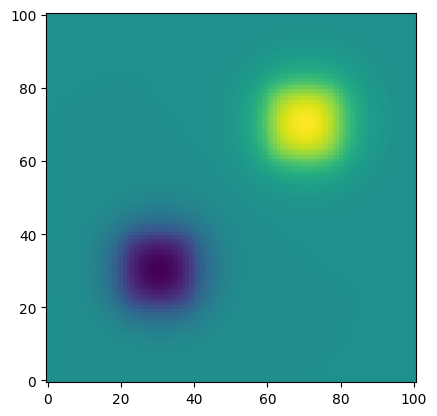

In [4]:
plt.imshow(phi, origin='lower')
plt.show()

## PDE Solving Method: Initial Value Problem
IVP: Variable of interest is not only subject to boundary conditions, but is also time varying.

Finite Time Centered Space Method

1-D wave equation

$
\cfrac{\partial^2 \phi}{\partial x^2} - \cfrac{1}{v^2} \cfrac{\partial^2 \phi}{\partial t^2} = 0
$

where can decomposed by,

$
\cfrac{d\phi}{dt}=\psi(x,t), \quad \cfrac{d\psi}{dt}= \cfrac{v^2}{a^2}[\phi(x+a,t)+ \phi(x-a,t) -2\phi(x,t)]
$

with initial condition

$
\phi(x,0)=0, \quad  \psi(x,0) = C\cfrac{x(L-x)}{L^2}\exp[-(x-d)^2/(2\sigma^2)]
$

In [5]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm

In [6]:
# Domain & simulation parameters
L = 1            # Length of the domain
N = 500          # Number of grid spacings
a = L / N      # Spatial step size
x = np.linspace(0, L, N+1)  # Spatial grid

# Physical parameters
v = 100        # Velocity constant
d = 0.1        # Shift position for the Gaussian-like shape
C = 1          # Amplitude constant
sigma = 0.3    # Wihh of the Gaussian

# Time stepping: use same h for both CN and FTCS updates.
h = 1e-6     # Time step per frame

def psi0(x):
    return C * x * (L - x) / L**2 * np.exp( - (x - d)**2 / (2 * sigma**2))

# Initial conditions
phi_FTCS = np.zeros_like(x)
psi_FTCS = psi0(x).copy()

# Prepare storage (for example, saving 200 frames)
num_frames = 100000
phi_FTCS_t = [phi_FTCS.copy()]

###############################################
# FTCS update (explicit) for one h step:
def update_FTCS(phi, psi):
    # FTCS: phi^{n+1} = phi^n + h * psi^n
    # and   psi^{n+1} = psi^n + h * v^2 * (phi_{i+1} - 2phi_i + phi_{i-1})/a^2
    phi_new = phi.copy()
    psi_new = psi.copy()

    phi_new[1:N] = phi[1:N] + h * psi[1:N]
    laplacian = (phi[2:N+1] - 2*phi[1:N] + phi[0:N-1])/(a**2)
    psi_new[1:N] = psi[1:N] + h * v**2 * laplacian
    return phi_new, psi_new

for _ in tqdm(range(num_frames)):
    phi_FTCS, psi_FTCS = update_FTCS(phi_FTCS, psi_FTCS)
    phi_FTCS_t.append(phi_FTCS.copy())

100%|██████████| 100000/100000 [00:01<00:00, 55369.96it/s]


In [7]:
fig, ax = plt.subplots()
line, = ax.plot(x - L/2, phi_FTCS_t[0], lw=2)
ax.set_xlabel('x - L/2')
ax.set_ylabel('psi')
ax.set_title('Wave Simulation')
ax.set_xlim(-L/2, L/2)
ax.set_ylim(-0.002, 0.002)

# -----------------------------
starting_frame = 0
# -----------------------------
def update(frame):
    frame = int(starting_frame + 100*frame)
    phi = phi_FTCS_t[frame]
    line.set_ydata(phi)
    return (line,)


ani = FuncAnimation(fig, update, frames=np.arange(0, 100), interval=10, blit=True)
plt.close(fig)
HTML(ani.to_jshtml())

## PDE Solving Method: Initial Value Problem
IVP: Variable of interest is not only subject to boundary conditions, but is also time varying.

Crank-Nicolson Method: hybrid of FTCS and Implicit method



In [8]:
import numpy as np
from tqdm import tqdm
from scipy.linalg import solve_banded
import matplotlib.pyplot as plt

# Domain & simulation parameters
L = 1            # Length of the domain
N = 500          # Number of grid spacings
a = L / N      # Spatial step size
x = np.linspace(0, L, N+1)  # Spatial grid

# Physical parameters
v = 100        # Velocity constant
d = 0.1        # Shift position for the Gaussian-like shape
C = 1          # Amplitude constant
sigma = 0.3    # Wihh of the Gaussian

# Time stepping: use same h for both CN and FTCS updates.
h = 1e-6     # Time step per frame

def psi0(x):
    return C * x * (L - x) / L**2 * np.exp( - (x - d)**2 / (2 * sigma**2))

# Initial conditions
phi_CN = np.zeros_like(x)
psi_CN = psi0(x).copy()

# Prepare storage (for example, saving 200 frames)
num_frames = 100000
phi_CN_t = [phi_CN.copy()]

###############################################
# CN update: 1 h-step update using trapezoidal rule
# CN derived update:
#   phi^{n+1} - r * δxx(phi^{n+1}) = phi^n + h*psi^n + r * δxx(phi^n)
# with r = h^2 * v^2/(4*a^2)
r = h**2 * v**2 / (4*a**2)
# Setup the banded matrix for interior nodes (1,...,N-1)
n_interior = N - 1
ab = np.zeros((3, n_interior))
ab[0, 1:] = -r             # Upper diagonal
ab[1, :] = 1 + 2*r         # Main diagonal
ab[2, :-1] = -r            # Lower diagonal

def update_CN(phi, psi):
    # Build right-hand side for interior nodes:
    lap_phi = (phi[2:N+1] - 2*phi[1:N] + phi[0:N-1])
    rhs = phi[1:N] + h*psi[1:N] + r * lap_phi  # note: lap_phi from phi^n

    # Solve for phi_interior^{n+1} via built-in banded solver
    phi_interior_new = solve_banded((1, 1), ab, rhs)

    phi_new = phi.copy()
    phi_new[1:N] = phi_interior_new

    # Update psi: psi^{n+1} = (2/h)*(phi^{n+1} - phi^n) - psi^n
    psi_new = psi.copy()
    psi_new[1:N] = (2/h)*(phi_new[1:N] - phi[1:N]) - psi[1:N]

    return phi_new, psi_new

###############################################
# Time stepping loop - update for both methods identically (num_frames h steps)
for _ in tqdm(range(num_frames)):
    phi_CN, psi_CN = update_CN(phi_CN, psi_CN)
    phi_CN_t.append(phi_CN.copy())


100%|██████████| 100000/100000 [00:08<00:00, 11793.62it/s]


In [9]:
fig, ax = plt.subplots()
line_ftcs, = ax.plot(x - L/2, phi_FTCS_t[0], lw=2, alpha=0.5)
line_cn, = ax.plot(x - L/2, phi_CN_t[0], lw=2, alpha=0.5)

ax.set_xlabel('x - L/2')
ax.set_ylabel('psi')
ax.set_title('Wave Simulation')
ax.set_xlim(-L/2, L/2)
ax.set_ylim(-0.002, 0.002)

# -----------------------------
starting_frame = 0
# -----------------------------
def update(frame):
    frame = int(starting_frame + 100*frame)
    line_ftcs.set_ydata(phi_FTCS_t[frame])
    line_cn.set_ydata(phi_CN_t[frame])

    return (line_ftcs, line_cn,)


ani = FuncAnimation(fig, update, frames=np.arange(0, 100), interval=10, blit=True)
plt.close(fig)
HTML(ani.to_jshtml())

# Deep Learning for differential equation

# Physics-Informed Neural Networks (PINNs)

## Example: Burgers' equation

To illustrate the PINN approach we consider the one-dimensional Burgers equation on the spatial domain $\mathcal{D} = [-1,1]$

$$
\begin{aligned}
    u_t + u u_x - \frac{0.01}{\pi}u_{xx} &= 0, \quad &&\quad (x,t) \in [-1,1] \times [0,1] \\
   u(x,0) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],\\
   u(-1, t) &= u(1, t) = 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

In [10]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt

def tdn(x):
    return x.cpu().detach().numpy()


device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Generate Training set

### Boundary condition

In [11]:
def init(x):
    return -torch.sin(torch.pi*x)

def bc(x):
    return x*0

In [12]:
def dataset_gen(gap=0.1):

    x = torch.arange(-1, 1+gap, gap)
    t = torch.arange(0, 1+gap, gap)
    x_col, t_col = torch.meshgrid(x, t)
    x_col, t_col = x_col.flatten(), t_col.flatten()

    x_bc_1, t_bc_1 = torch.meshgrid(x[0], t)
    x_bc_1, t_bc_1 = x_bc_1.squeeze(), t_bc_1.squeeze()
    u_bc_1 = bc(x_bc_1)

    x_bc_2, t_bc_2 =  torch.meshgrid(x[-1], t)
    x_bc_2, t_bc_2 = x_bc_2.squeeze(), t_bc_2.squeeze()
    u_bc_2 = bc(x_bc_2)

    x_init, t_init =  torch.meshgrid(x, t[0])
    x_init, t_init = x_init.squeeze(), t_init.squeeze()
    u_init = init(x_init)

    x_bc = torch.cat([x_bc_1, x_bc_2, x_init])
    t_bc = torch.cat([t_bc_1, t_bc_2, t_init])
    u_bc = torch.cat([u_bc_1, u_bc_2, u_init])

    return x_col, t_col, x_bc, t_bc, u_bc

C:\Users\pco0511\AppData\Roaming\Python\Python312\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 1.0, 'Positions of collocation & boundary points')

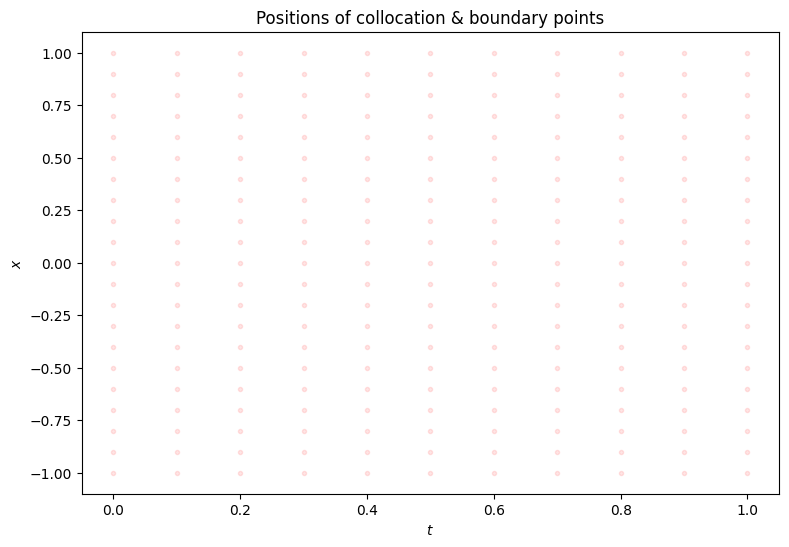

In [ ]:
x_coll, t_coll, x_bc, t_bc, u_bc = dataset_gen()

fig = plt.figure(figsize=(9,6))
plt.scatter(tdn(t_bc), tdn(x_bc), c=tdn(u_bc), marker='X', vmin=-1, vmax=1)
plt.scatter(tdn(t_coll), tdn(x_coll), c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Positions of collocation & boundary points')

## 2. Define Neural Network and Define Loss with residual

### Define Loss function

\begin{equation}
J_d = \cfrac{1}{N} \sum^{N}_{i=1} \left[u_\theta(x_d^{(i)}, t_d^{(i)})-u^{(i)}\right]^2
\end{equation}


\begin{equation}
J_p = \cfrac{1}{N} \sum^{N}_{i=1} \left[f(x_p^{(i)}, t_p^{(i)})\right]^2, \quad \text{where} \quad f(x,t) = u_t + uu_x - \left( \cfrac{0.01}{\pi} \right)u_{xx}
\end{equation}


In [ ]:

def burger_equation_residual(data, u):
    # input data: (x,t), function: u
    # function is must explicitly relate with input u ~ f(x,t, ...)
    # Calculate the first derivative with respect to dx, dt: du/dx, du/dt
    du_dX = torch.autograd.grad(u, data, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]

    # Calculate the first derivative with respect to x: du/dx
    du_dx = du_dX[:,0]
    du_dt = du_dX[:,1]

    # Calculate the second derivative with respect to x: d2u/dx2
    du_dxx = torch.autograd.grad(du_dX, data, grad_outputs=torch.ones_like(du_dX), retain_graph=True, create_graph=True)[0][:,0]
    # Define the residual of the PDE: du/dt + u du/dx - alpha * d2u/dx2
    residual = du_dt + u.squeeze()*du_dx - (0.01/torch.pi)*du_dxx
    return residual

def Jd(u_pred, u_true):
    if u_pred.size()==u_true.size():
        pass
    else:
        raise TypeError
    return torch.mean((u_pred - u_true)**2)

def Jp(data, u_pred):
    f_pred = burger_equation_residual(data, u_pred)
    return torch.mean(f_pred**2)



In [ ]:
import torch.nn as nn

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()

        self.fc1 = nn.Linear(2, 20)

        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 20)
        self.fc5 = nn.Linear(20, 20)

        self.fc = nn.Linear(20, 1)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x)
        x = self.activation(x)
        x = self.fc5(x)
        x = self.activation(x)
        x = self.fc(x)

        return x


## 3. Train Model
We use the LBFGS optimizer because, with periodic boundary conditions, a simple gradient approach tends to get stuck in poor local minima.


In [ ]:

class PINN_Optimizer:
    def __init__(self):
        self.model = PINN().to(device)
        x_coll, t_coll, x_bc, t_bc, u_bc = dataset_gen(gap=0.1)
        self.data_coll = torch.stack([x_coll, t_coll], dim=-1).to(device).requires_grad_(True)
        self.data_bc =  torch.stack([x_bc, t_bc], dim=-1).to(device)
        self.u_bc_true = u_bc.to(device).unsqueeze(1)

        self.iter = 1
        self.optimizer = torch.optim.LBFGS(self.model.parameters(),
                                           lr=1,
                                           max_iter=50000,
                                           max_eval=50000,
                                           history_size=50,
                                           tolerance_grad=1e-7,
                                           tolerance_change=1.0 * np.finfo(float).eps,
                                           line_search_fn="strong_wolfe"
                                          )
        self.adam = torch.optim.Adam(self.model.parameters())

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        u_pred_coll = self.model(self.data_coll)
        J_p = Jp(self.data_coll, u_pred_coll)


        u_pred_bc = self.model(self.data_bc)
        J_d = Jd(u_pred_bc, self.u_bc_true )

        loss = J_d + J_p
        loss.backward()
        if self.iter % 100 == 0:
            print(f"Optimize Iteration: {self.iter}, J_p:  {J_p.item():.4f}, J_d: {J_d.item():.4f}, Total: {loss.item():.4f}")
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

In [ ]:
PINN_Opt = PINN_Optimizer()
PINN_Opt.train()

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Optimize Iteration: 100, J_p:  0.0061, J_d: 0.1792, Total: 0.1854
Optimize Iteration: 200, J_p:  0.0275, J_d: 0.0656, Total: 0.0931
Optimize Iteration: 300, J_p:  0.0259, J_d: 0.0633, Total: 0.0891
Optimize Iteration: 400, J_p:  0.0232, J_d: 0.0592, Total: 0.0825
Optimize Iteration: 500, J_p:  0.0216, J_d: 0.0509, Total: 0.0725
Optimize Iteration: 600, J_p:  0.0211, J_d: 0.0486, Total: 0.0697
Optimize Iteration: 700, J_p:  0.0208, J_d: 0.0468, Total: 0.0676
Optimize Iteration: 800, J_p:  0.0203, J_d: 0.0452, Total: 0.0656
Optimize Iteration: 900, J_p:  0.0200, J_d: 0.0429, Total: 0.0629
Optimize Iteration: 1000, J_p:  0.0175, J_d: 0.0338, Total: 0.0513
Optimize Iteration: 1100, J_p:  0.0084, J_d: 0.0083, Total: 0.0167
Optimize Iteration: 1200, J_p:  0.0046, J_d: 0.0044, Total: 0.0089
Optimize Iteration: 1300, J_p:  0.0040, J_d: 0.0019, Total: 0.0058
Optimize Iteration: 1400, J_p:  0.0026, J_d: 0.0014, Total: 0.0040
Optimize Iteration: 1500, J_p:  0.0022, J_d: 0.0012, Total: 0.0034
Opti

## Visualization

In [ ]:
x_coll, t_coll, x_bc, t_bc, u_bc = dataset_gen(0.01)

data_coll = torch.stack([x_coll.requires_grad_(True),
                         t_coll.requires_grad_(True)], dim=-1).to(device)

trained_model = PINN_Opt.model
trained_model.eval()
with torch.no_grad():
    y_pred = trained_model(data_coll)

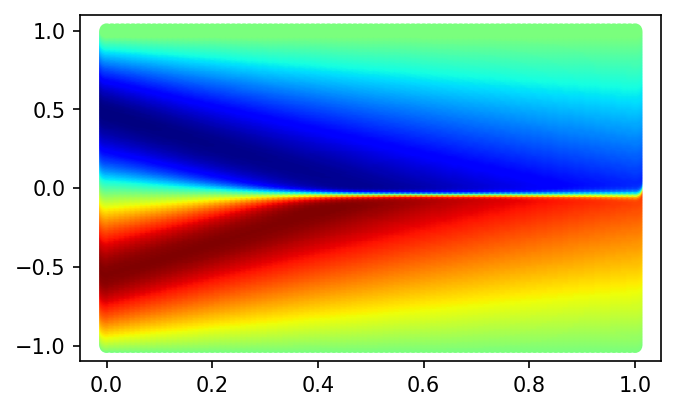

In [ ]:
x = tdn(x_coll)
t = tdn(t_coll)
c = tdn(y_pred)


plt.figure(figsize=(5, 3), dpi=150)
plt.scatter(t, x, c=c, cmap='jet')
plt.show()

# (Optional) Stochastic Process & PDE

## Example: Heat Equation

\begin{equation}
\cfrac{\partial u}{\partial t}(x,t) = \nabla^2 u(x,t), \quad u(x,0) = ||x||^2
\end{equation}

Let's match with below partial differential equation
\begin{equation}
\cfrac{\partial u}{\partial t}(x,t) - \mu(x,t) \cfrac{\partial u}{\partial x}(x,t) - \cfrac{1}{2}\sigma^2(x,t) \cfrac{\partial^2 u}{\partial x^2}(x,t) = 0
\end{equation}

Then, the problem is initial value problem with $\mu(x,t)=0, \sigma(x,t)=\sqrt{2}$ under domain $x\in \mathcal{D} \equiv [0,1]$

## 1. Generation of training data
We can generate solution of partial differential equation via random process.

since $\mu=0$, we can simply generate random process $X$, as follows

\begin{equation}
\therefore X(T) := X(0) + \sigma \sqrt{T}\xi, \quad X(0)=x_0 \sim \mathcal{U}(D), \quad \text{where} \quad \xi \sim \mathcal{N}(0,1)
\end{equation}

Then, by define $g(x)\equiv u(x,0)$ (fixed time) we can access differential equation's solution by
\begin{equation}
u(x, T-t) = \mathbb{E}[g(X(T))|X(t)=x] \Rightarrow u(x_0,T) \approx \cfrac{1}{n} {\sum^n} g(X(T)) = \mathbb{E}[y]
\end{equation}

In [ ]:
def draw_X(num_samples, T=1):
    dim = 1
    X0 = torch.rand(size=(num_samples,dim))

    noise = torch.randn(size=(num_samples,dim))

    XT = X0 + np.sqrt(2) * np.sqrt(T) * noise

    # Return simulated paths as well as increments of Brownian motion
    return X0, XT

# initial condition, g(x) = u(x,t=0)
def fun_g(x):
    return torch.sum(x**2, dim=-1).unsqueeze(1)

## 2. Define Simple Neural Network

In [ ]:
import torch.nn as nn

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()

        self.fc1 = nn.Linear(1, 20)

        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)

        self.fc = nn.Linear(20, 1)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc(x)

        return x


## 3. Define objective (Loss) function
From $u(x, T-t) = \mathbb{E}[g(X(T))|X(t)=x]$, If we approximate the function $u(x,T)$ as neural network $u_\theta$, the objective function is simply define as follows

\begin{equation}
\cfrac{1}{N}\sum^N || u_\theta(x,T)-\mathbb{E}[g(X(T))|X(t=0)=x]||^2
\end{equation}

In [ ]:
def loss_func(u_pred, u_true):
    if u_pred.size()==u_true.size():
        pass
    else:
        raise TypeError
    return torch.mean((u_pred-u_true)**2)

## 4. Training

In [ ]:
model = NN()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


model.train()
num_epochs = 5000
for epoch in range(num_epochs):
    optimizer.zero_grad()


    X0, XT = draw_X(num_samples=2500)
    u_x_T = model(X0.to(device))
    g_X_T = fun_g(XT.to(device))

    loss = loss_func(u_x_T, g_X_T)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')


Epoch [1000/5000], Loss: 10.040108
Epoch [2000/5000], Loss: 9.841575
Epoch [3000/5000], Loss: 10.683661
Epoch [4000/5000], Loss: 10.843809
Epoch [5000/5000], Loss: 11.582214


## Visualization

In [ ]:
x = torch.arange(0, 1+0.01, 0.01).view(-1,1)
model.eval()
with torch.no_grad():
    u_T = model(x.to(device))

In [ ]:
## simple exact solution
def fun_u_T(x, T=1):
    return torch.sum(x**2, dim=-1) + 2 * T

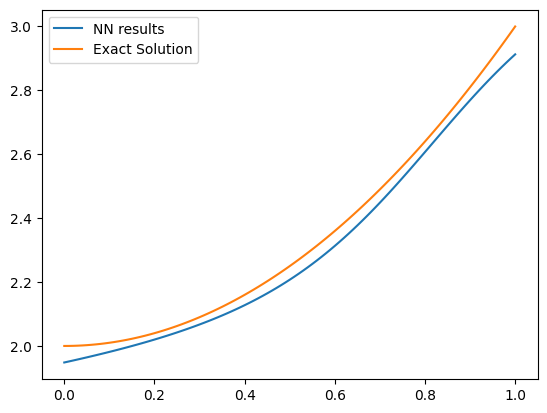

In [ ]:
plt.plot(tdn(x), tdn(u_T), label="NN results")
plt.plot(tdn(x), tdn(fun_u_T(x)), label="Exact Solution")
plt.legend()
plt.show()